In [13]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../..'))

from PySDM.physics import si
from PySDM.initialisation.spectral_sampling import ConstantMultiplicity
from PySDM.initialisation.spectra import Gaussian
from PySDM.physics.formulae import volume

# 1. Constant Kernel = 8e-5
** Make everything dimensionless, and set the time step to something smaller than the kernel constant

Note that there are norm_factor total droplets represented

98304.0
19676.0
Average final particle size:  74.9420613945923


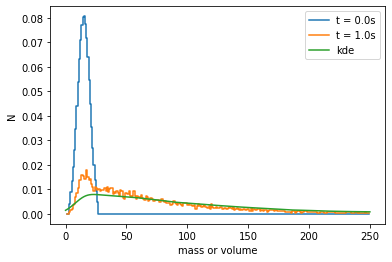

In [24]:
# Set desired constants
K      = 8e-5          # Kernel constant
dt_sim = 1e-3          # time step
T_sim  = 1             # total time of simulation
n_sd   = 2**14         # number of superdroplets
N0     = 1e5           # total number of droplets
end_step = int(T_sim / dt_sim)
kde_fac= 0.1
mu = 15
sigma = 5

# initial distribution
initial_spectrum = Gaussian(norm_factor=N0, loc=15, scale=5)
attributes = {}
attributes['volume'], attributes['n'] =\
    ConstantMultiplicity(spectrum=initial_spectrum).sample(n_sd)

from PySDM import Builder
from PySDM.environments import Box
from PySDM.dynamics import Coalescence
from PySDM.dynamics.coalescence.kernels import ConstKern
from PySDM.backends import CPU
from PySDM.products.state import ParticlesVolumeSpectrum, ParticlesNumberVolumeSpectrum, KthMoment

builder = Builder(n_sd=n_sd, backend=CPU)
builder.set_environment(Box(dt=dt_sim, dv=1))
builder.add_dynamic(Coalescence(kernel=ConstKern(kernel_const = K)))
products = [ParticlesVolumeSpectrum(), ParticlesNumberVolumeSpectrum(), KthMoment()]
particles = builder.build(attributes, products)

from matplotlib import pyplot
import numpy as np

v_bins_edges = np.linspace((1), (250), num=251)

for step in [0, end_step]:
    particles.run(step - particles.n_steps)
    pyplot.step(x=v_bins_edges[:-1],
                y=particles.products['N(v)'].get(v_bins_edges)/particles.products['Mk'].get(0),
                where='post', label=f"t = {step*dt_sim}s")
    print((particles.products['Mk'].get(0)))

print("Average final particle size: ", particles.products['Mk'].get(1)/particles.products['Mk'].get(0))

## Interpolate it back to a smooth function
from scipy import stats
kde_pts = particles.particles.get_extensive_attrs().to_ndarray()
kde = stats.gaussian_kde(kde_pts[0], kde_fac)

x = np.linspace(0,250,500)
y = kde(x)
pyplot.plot(x ,y, label="kde")

pyplot.xlabel('mass or volume')
pyplot.ylabel("N")
pyplot.legend()

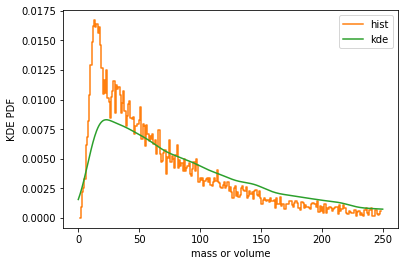

In [15]:
from scipy import stats
kde_fac = 0.1
## Interpolate it back to a smooth function
kde_pts = particles.particles.get_extensive_attrs().to_ndarray()
kde = stats.gaussian_kde(kde_pts[0], kde_fac)

x = np.linspace(0,250,500)
y = kde(x)
pyplot.plot(0, 0)
pyplot.step(x=v_bins_edges[:-1],
            y=particles.products['N(v)'].get(v_bins_edges)/particles.products['Mk'].get(0),
           label="hist")
pyplot.plot(x ,y, label="kde")
pyplot.xlabel("mass or volume")
pyplot.ylabel("KDE PDF")
pyplot.legend()

## Distribution comparison:
We have 
- kde(x), the superdroplets
- rbf(x), the collocation method
- mom(x), the original Cloudy MOM

Updated 10/23/2020 with new constants

In [16]:
# import rbf from julia setup
from scipy.stats import norm

def gauss_basis(x, mean, stddev):
    return norm.pdf(x, loc=mean, scale=stddev)

def rbf_basis(x, constants, means, stddev):
    N = len(means)
    assert (len(stddev) == N)
    assert (len(constants) == N)
    pdf_result = 0
    
    for i in range(N):
        pdf_result += constants[i]*gauss_basis(x, means[i], stddev[i])
        
    return pdf_result

def rbf3(x):
    means = [15.0, 47.434164902525694, 149.99999999999997]
    stddev = [5.0, 64.10364693592142, 64.10364693592142]
    c =  [0.19684017326510342, 0.4379048727292109, 0.3652549540056857]
    return rbf_basis(x, c, means, stddev)

def rbf6(x):
    means =  [15.0, 23.773397886916698, 37.678296472643694, 59.71607558302459, 94.64360167202898, 149.99999999999997]
    stddev = [5.0, 8.690561616079373, 13.77361194398806, 21.82970380562774, 34.59774895498187, 34.59774895498187]
    c =  [0.04236765991878158, 0.10492872096161311, 0.1496066482090059, 0.25599604897731715, 0.2914804760798675, 0.1556204458534148]
    return rbf_basis(x, c, means, stddev)
    
def rbf10(x):
    means =  [15.0, 20.0025079647447, 26.67335499197833, 35.568933044900625, 47.43119110187304, 63.2495185195029, 84.34326653017487, 112.47179070282719, 149.98119262282665, 199.99999999999994]
    stddev = [5.0, 4.169279392021017, 5.559736283076435, 7.413911285607759, 9.886454636018662, 13.183592506669983, 17.580327607907698, 23.443376199999662, 31.261754610733306, 31.261754610733306]
    c = [0.10851110223193534, 2.3007775504388272e-9, 0.12175065269343695, 0.0725394218887698, 0.1398835119274269, 0.13619427166904985, 0.10585500056874539, 0.1981845200314884, 1.369746136291741e-8, 0.11708150299090835]
    return rbf_basis(x, c, means, stddev)
    

In [17]:
# import cloudy from julia setup
def mom(x):
    mean = 75.02983189048025
    stddev = 68.0114957945617
    return norm.pdf(x, loc=mean, scale=stddev)


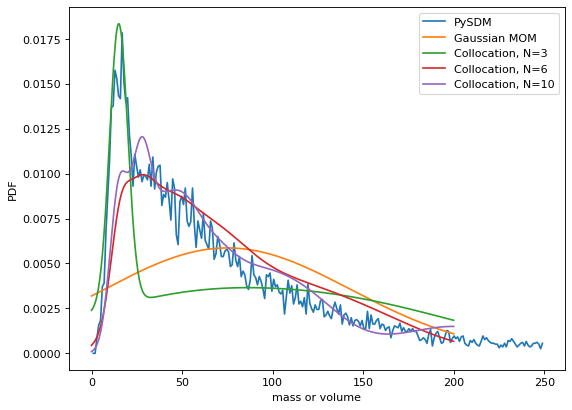

In [26]:
# plot all of them
pyplot.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
x = np.linspace(0,200,500)
x_sdm=v_bins_edges[:-1]
y_sdm=particles.products['N(v)'].get(v_bins_edges)/particles.products['Mk'].get(0)
pyplot.plot(x_sdm, y_sdm, label="PySDM")
#ykde = kde(x)
#pyplot.plot(x ,ykde, label="PySDM")
ymom = mom(x)
pyplot.plot(x, ymom, label="Gaussian MOM")
yrbf3 = rbf3(x)
pyplot.plot(x, yrbf3, label="Collocation, N=3")
yrbf6 = rbf6(x)
pyplot.plot(x, yrbf6, label="Collocation, N=6")
yrbf10 = rbf10(x)
pyplot.plot(x, yrbf10, label="Collocation, N=10")

pyplot.xlabel("mass or volume")
pyplot.ylabel("PDF")
pyplot.legend()

In [19]:
# KL Divergence of 2 metrics
from scipy.stats import entropy

def kl_div(qk, pk):
    return entropy(qk, pk)

print("PySDM: ", kl_div(ykde, ykde))
print("MOM: ", kl_div(ykde, ymom))
print("RBF3: ", kl_div(ykde, yrbf3))
print("RBF6: ", kl_div(ykde, yrbf6))
print("RBF10: ", kl_div(ykde, yrbf10))

PySDM:  0.0
MOM:  0.042778837885590754
RBF3:  0.13580158750959354
RBF6:  0.018063949069353935
RBF10:  0.05032019235657831


In [20]:
# KS test

def ks_test(qk, pk):
    dists = abs(qk - pk)
    return max(dists)

print("PySDM: ", ks_test(ykde, ykde))
print("MOM: ", ks_test(ykde, ymom))
print("RBF3: ", ks_test(ykde, yrbf3))
print("RBF6: ", ks_test(ykde, yrbf6))
print("RBF10: ", ks_test(ykde, yrbf10))

PySDM:  0.0
MOM:  0.0036196583599264753
RBF3:  0.011375601617617128
RBF6:  0.0021919769030552833
RBF10:  0.004252365678518079


In [21]:
# W1 distance (empirical)
from scipy.stats import wasserstein_distance

def w1(qk, pk):
    return wasserstein_distance(qk, pk)

print("PySDM: ", w1(ykde, ykde))
print("MOM: ", w1(ykde, ymom))
print("RBF3: ", w1(ykde, yrbf3))
print("RBF6: ", w1(ykde, yrbf6))
print("RBF10: ", w1(ykde, yrbf10))

PySDM:  0.0
MOM:  0.000675285974050047
RBF3:  0.0016147150742949904
RBF6:  0.0007465768235161684
RBF10:  0.0009916110822248466


## Ouputting Moments
Either the k'th or the first k moments can be output with my defined state products.

initial moments:  [   98304.          1474560.         24265027.43164101]
final moments:  [1.98840000e+04 1.47456000e+06 1.99376533e+08]


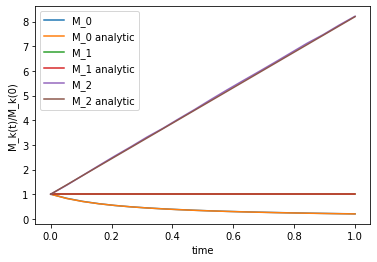

In [22]:
# Plot the moments over time
n_time = 20
from PySDM.products.state import KMoments

builder = Builder(n_sd=n_sd, backend=CPU)
builder.set_environment(Box(dt=dt_sim, dv=1))
builder.add_dynamic(Coalescence(kernel=ConstKern(kernel_const = K)))
products = [KMoments()]
particles = builder.build(attributes, products)

k = 3
tsteps = range(n_time)
Mk = np.zeros((len(tsteps), k))
Mk_norm = np.zeros((len(tsteps), k))

for i, step in enumerate(tsteps):
    step = int(end_step*step/(n_time-1))
    particles.run(step - particles.n_steps)
    Mk[i,:] = (particles.products['M0-Mk'].get(k))
    Mk_norm[i,:] = Mk[i,:] / Mk[0,:]
    
# Analytic solutions
def const_kern_M012_norm_analytic(M_0, t, a):
    M0 = 1/(1/M_0[0] + 1/2*a*t)
    M1 = M_0[1]
    M2 = M_0[2] + a*M_0[1]**2*t
    return [M0/M_0[0], M1/M_0[1], M2/M_0[2]]

mu = 15
sigma = 5
M_0 = [N0, N0*mu, N0*(mu**2 + sigma**2)]
Mk_norm_analytic = np.zeros((len(tsteps), k))

for i, step in enumerate(tsteps):
    t = T_sim*step/(n_time-1)
    Mk_norm_analytic[i,:] = const_kern_M012_norm_analytic(M_0,t,K)

for j in range(k):
    pyplot.plot([t/(n_time-1)*T_sim for t in tsteps], Mk_norm[:,j], label=f"M_{j}")
    pyplot.plot([t/(n_time-1)*T_sim for t in tsteps], Mk_norm_analytic[:,j], label=f"M_{j} analytic")
    
pyplot.xlabel("time")
pyplot.ylabel("M_k(t)/M_k(0)")
pyplot.legend()

print("initial moments: ", Mk[0,:])
print("final moments: ", Mk[-1,:])